In [123]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.optim import Adam
import operator
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics

In [2]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [189]:
yeast = pd.read_csv('yeast.csv', header=None)
yeast.columns = ["seq_name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "classname"]
abalone = pd.read_csv('abalone.csv', header=None)
abalone.columns = ["sex", "length", "diameter", "height", "whole_height", "shucked_weight", "viscera_weight", "shell_weight", 
                   "classname"]
iris = pd.read_csv('iris.csv', header=None)
iris.columns = ["petalLength", "petalWidth", "sepalLength", "sepalWidth", "classname"]
glass = pd.read_csv('glass.csv', header=None)
glass.columns = ["id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "classname"]
glass = glass.set_index('id')
pima = pd.read_csv('pima-diabetes.csv', header=None)
pima.columns = ["NumTimesPrg", "PlGlcConc", "BloodP", "SkinThick", "TwoHourSerIns", "BMI", "DiPedFunc","Age", "classname"]
wine = pd.read_csv('wine.csv', header=None)
wine.columns = ["classname", "Alcohol", "MalicAcid", "Ash", "AlcalinityOfAsh", "Magnesium", "TotalPhenols","Flavanoids", 
                "NonflavanoidPhenols", "Proanthocyanins", "ColorIntensivity", "Hue","OD280/OD315", "Proline"]

df = wine
num_columns = df.shape[1]
num_rows = df.shape[0]
#data = torch.tensor(df.values).float()
data = df

#print(data)

In [190]:
# sns.pairplot(data, kind="scatter", diag_kind="hist", hue="class")

In [199]:
def model(data):
    data = torch.tensor(data.values).float()
    
    mean_prior = data[0]
    std_prior = torch.ones(num_columns)
#     noise_std = torch.ones(num_columns)
    
    prior = pyro.distributions.Normal(loc=mean_prior, scale=std_prior).independent(1)
    weight = pyro.sample("weight", prior)
    
    with pyro.plate("map", len(data)):
        #sample = pyro.sample("obs", pyro.distributions.Normal(weight, noise_std), obs=data)
        sample = pyro.sample("obs", prior, obs=data)
        return sample


def guide(data):
    mean = pyro.param("mean", torch.ones(1, num_columns)*0)
    std = pyro.param("std", torch.ones(1, num_columns)*10, constraint=constraints.positive)
    
    dists = pyro.distributions.Normal(loc=mean, scale=std).independent(1)
    sample = pyro.sample("weight", dists)
    return sample

In [206]:
%%time
def train(data, num_steps=5000):
    pyro.clear_param_store()
    
    optim = Adam({"lr": 0.07})
    svi = pyro.infer.SVI(model=model,
                         guide=guide,
                         optim=optim,
                         loss=pyro.infer.Trace_ELBO(), num_samples=len(data))

    losses = []
    for t in tqdm(range(num_steps)):
        losses.append(svi.step(data))
    return pyro.param("mean"), pyro.param("std"), losses

_, _, losses = train(data, 20000)


Wall time: 1min 17s


Index(['classname', 'Alcohol', 'MalicAcid', 'Ash', 'AlcalinityOfAsh',
       'Magnesium', 'TotalPhenols', 'Flavanoids', 'NonflavanoidPhenols',
       'Proanthocyanins', 'ColorIntensivity', 'Hue', 'OD280/OD315', 'Proline'],
      dtype='object')
[1.9382022471910112, 13.00061797752809, 2.3363483146067416, 2.3665168539325845, 19.49494382022472, 99.74157303370787, 2.295112359550562, 2.0292696629213487, 0.3618539325842696, 1.5908988764044945, 5.058089882022472, 0.9574494382022471, 2.6116853932584267, 746.8932584269663]
[0.7728548591122252, 0.8095429145285168, 1.1140036269797893, 0.27357229442643255, 3.3301697576582128, 14.242307673359806, 0.6240905641965369, 0.996048950379233, 0.12410325988364795, 0.5707488486199379, 2.3117646609525573, 0.22792860656507252, 0.7079932646716005, 314.0216568419878]

learned mean =  [0.9088855385780334, 14.673995971679688, 1.7297182083129883, 2.487793207168579, 15.520822525024414, 126.75790405273438, 2.7235190868377686, 3.0372507572174072, 0.21620814502239227, 

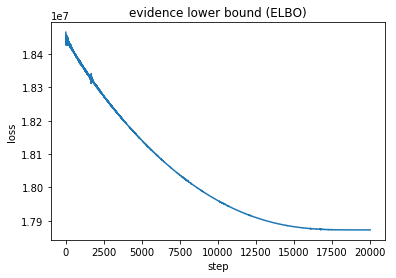

In [207]:
def plot_loss(losses, learned_mean, learned_std, print_info=False):
    columns_data = [df[i] for i in df.columns]
    
    true_mean = [np.mean(x) for x in columns_data]
    true_std = [np.std(x) for x in columns_data]
    if (print_info):
        print(df.columns)
        print("{}\n{}".format(true_mean, true_std))
        print()

    plt.plot(losses)
    plt.title("evidence lower bound (ELBO)")
    plt.xlabel("step")
    plt.ylabel("loss");
    if (print_info):
        print('learned mean = ', learned_mean)
        print('learned std = ', learned_std)
        print()

    diff_mean = [learned_mean[i] - true_mean[i] for i in range(len(true_mean))]
    diff_std = [learned_std[i] - true_std[i] for i in range(len(true_std))]
    if (print_info):
        print(diff_mean, "\n", diff_std)
    

learned_mean = pyro.param("mean").tolist()[0]
learned_std = pyro.param("std").tolist()[0]

plot_loss(losses, learned_mean, learned_std, print_info=True)

In [173]:
def extract_labels(dataset):
    # extract labels
    dataset_labels = dataset["classname"].copy()
    dataset = dataset.drop("classname", axis=1)

    return dataset, dataset_labels


def split_data(dataset, test_size=0.2):
    # split into train and test sets
    train_set, test_set = train_test_split(dataset, test_size=test_size, random_state=42, stratify=dataset['classname'])

    # extract labels
    train_set_labels = train_set["classname"].copy()
    train_set = train_set.drop("classname", axis=1)

    test_set_labels = test_set["classname"].copy()
    test_set = test_set.drop("classname", axis=1)

    return train_set, train_set_labels, test_set, test_set_labels


def evaluate(labels_true, labels_predicted):
    labels_true = labels_true.values.tolist()
    accuracy = metrics.accuracy_score(y_true=labels_true, y_pred=labels_predicted)
    precision = metrics.precision_score(y_true=labels_true, y_pred=labels_predicted, average='macro')
    recall = metrics.recall_score(y_true=labels_true, y_pred=labels_predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels_true, y_pred=labels_predicted, average='macro')

    return accuracy, precision, recall, f1


def test_classifier(train, train_labels, test, test_labels, model):
    model.fit(train, train_labels)
    labels_predicted = model.predict(test)
    labels_true = test_labels
    accuracy, precision, recall, f1 = evaluate(labels_true, labels_predicted)
    return accuracy, precision, recall, f1

In [182]:
class NaiveBayesClassifier:
    def __init__(self):
        self.mean_for_classes = {}
        self.std_for_classes = {}
        self.classes_probs = {}
    
    def fit(self, X, y):
        self.classes = y.unique()
        
        for classname in self.classes:
            current_data = X[y==classname]
            self.classes_probs[classname] = len(current_data)
            # TODO: priors - pierwsze elementy z każdej kolumny??
            mean, std, _ = train(current_data, num_steps=10000)
            self.mean_for_classes[classname] = mean[0]
            self.std_for_classes[classname] = std[0]
            # print(self.classes_probs[classname], self.mean_for_classes[classname], self.std_for_classes[classname])
            
    
    def predict(self, X):
        probs = {}
        predicted = []
        
        for row in X.values:
            for classname in self.classes:
                p = self.classes_probs[classname]
                for i, element in enumerate(row):
                    p *= (1/(np.sqrt(2*np.pi*self.std_for_classes[classname][i].detach().numpy() ** 2))) \
                            * np.e ** \
                            (-((element-self.mean_for_classes[classname][i].detach().numpy()) ** 2) \
                             /(2*self.std_for_classes[classname][i].detach().numpy() ** 2))
                    # print(p)
                probs[classname] = p
            chosen_class = max(probs.items(), key=operator.itemgetter(1))[0]
            predicted.append(chosen_class)
        
        return predicted


In [183]:
def classify(dataset):
    train_set, train_labels, test_set, test_labels = split_data(dataset)
    model = NaiveBayesClassifier()
    accuracy, precision, recall, f1 = test_classifier(train_set, train_labels, test_set, test_labels, model)
    return accuracy, precision, recall, f1

In [184]:
# bayes = NaiveBayesClassifier()
# data_labels = data["classname"].copy()
# data_no_labels = data.drop("classname", axis=1)
# num_columns = data_no_labels.shape[1]
# bayes.fit(data_no_labels, data_labels)

In [186]:
classify(data)

d:\programowanie\python\machine-learning-tests\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\programowanie\python\machine-learning-tests\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.5, 0.34055727554179566, 0.5333333333333333, 0.41379310344827586)